In [49]:
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Maxcut
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2
from qiskit.primitives import BackendSamplerV2
from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

# initialize service to access real backends
service = QiskitRuntimeService()

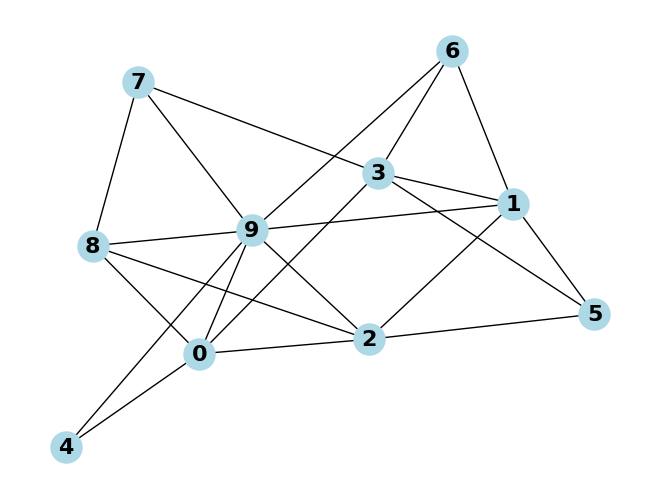

In [50]:
# Problem setup 
n = 10  # Number of nodes
p = 7  # Number of layers

# Create a random graph with weights
random.seed(42)  # For reproducibility
G = nx.erdos_renyi_graph(n, 0.5)  # Random graph with n nodes and p edges
for (u, v) in G.edges():
    G[u][v]['weight'] = random.uniform(1.0, 1.0)

edges = G.edges()
pos = nx.spring_layout(G)  # Layout for visualization
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=16, font_weight='bold')

# weight matrix
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        if temp := G.get_edge_data(i, j, default=0):
            w[i][j] = temp["weight"]

# cost function and cost hamiltonian
quadratic_program = Maxcut(w).to_quadratic_program()
op, offset = quadratic_program.to_ising()


In [51]:
print(op)

SparsePauliOp(['IIIIIIIZIZ', 'IIIIIIZIIZ', 'IIIIIZIIIZ', 'IZIIIIIIIZ', 'ZIIIIIIIIZ', 'IIIIIIIZZI', 'IIIIIIZIZI', 'IIIIZIIIZI', 'IIIZIIIIZI', 'ZIIIIIIIZI', 'IIIIZIIZII', 'IZIIIIIZII', 'ZIIIIIIZII', 'IIIIZIZIII', 'IIIZIIZIII', 'IIZIIIZIII', 'ZIIIIZIIII', 'ZIIZIIIIII', 'IZZIIIIIII', 'ZIZIIIIIII', 'ZZIIIIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [52]:
initial_params = [1.55211052, 0.93755857, 3.42364597, 3.10825601, 1.60421616, 0.10089037, 1.4628155, 0.42658842, 2.61708663, 2.70423488, 2.4527487, 1.69922681, 0.73495372, 2.32907512]
gamma = initial_params[:p]
beta = initial_params[p:]
initial_params_1 = np.random.uniform(0, 2 * np.pi, size=2 * p)
gamma_1 = initial_params_1[:p]
beta_1 = initial_params_1[p:]

c:\Users\shubh\miniconda3\envs\cwq\Lib\site-packages\qiskit\visualization\circuit\matplotlib.py:269: UserWarning: Style JSON file 'iqx.json' not found in any of these locations: c:\Users\shubh\miniconda3\envs\cwq\Lib\site-packages\qiskit\visualization\circuit\styles\iqx.json, iqx.json. Will use default style.
  self._style, def_font_ratio = load_style(self._style)


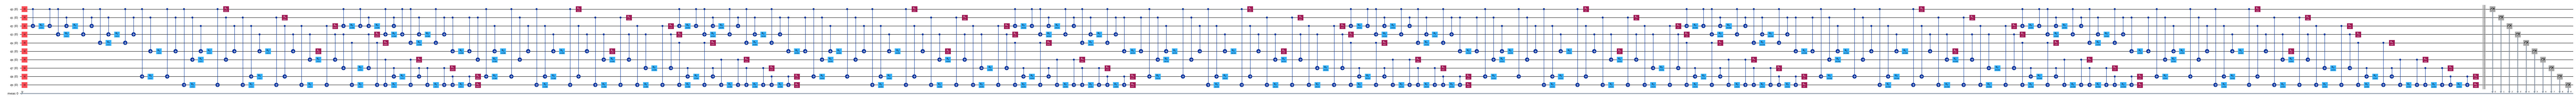

In [53]:
circuit = QuantumCircuit(n)
for i in range(n):
    circuit.h(i)
#qc.draw('mpl')
for layer in range(0, p, 1):
    for i, j in edges:
        circuit.cx(i, j)
        circuit.rz(-2 * gamma[layer], j)
        circuit.cx(i, j)
    for qubit in range(circuit.num_qubits):
        circuit.rx(2 * beta[layer], qubit)

circuit.measure_all()
circuit.draw('mpl', fold=-1, style='iqx', scale=0.5, initial_state=True)

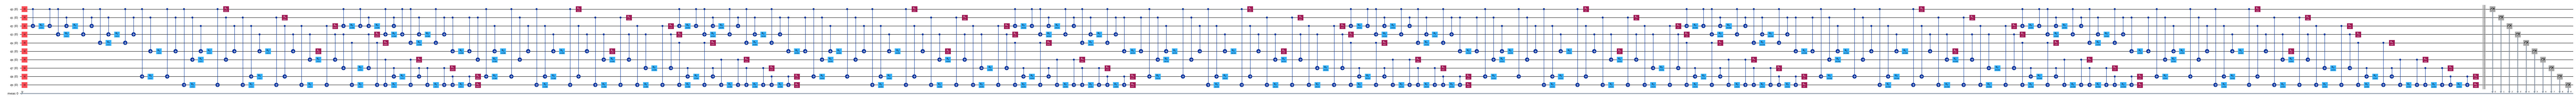

In [54]:
circuit2 = QuantumCircuit(n)
for i in range(n):
    circuit2.h(i)
#qc.draw('mpl')
for layer in range(0, p, 1):
    for i, j in edges:
        circuit2.cx(i, j)
        circuit2.rz(-2 * gamma[layer], j)
        circuit2.cx(i, j)
    for qubit in range(circuit2.num_qubits):
        circuit2.rx(2 * beta[layer], qubit)

circuit2.measure_all()
circuit2.draw('mpl', fold=-1, style='iqx', scale=0.5, initial_state=True)

In [55]:
ideal_simulator = AerSimulator()
transpiled_circuit_ideal = transpile(circuit, ideal_simulator)
transpiled_circuit_ideal2 = transpile(circuit2, ideal_simulator)

In [56]:
def expectation_from_counts(counts, edges):
    """
    Calculate the expectation value for the MaxCut problem from measurement counts.
    """
    expectation = 0
    total_shots = sum(counts.values())
    for bitstring, count in counts.items():
        z = [int(bit) for bit in bitstring[::-1]]  # Reverse bitstring to match qubit order
        cut_value = sum(1 for i, j in edges if z[i] != z[j])
        expectation += cut_value * (count / total_shots)
    return expectation

def cost_function(params, backend, m):
    # Create full parameter arrays
    optimized_beta = beta.copy()
    optimized_gamma = gamma.copy()
    # Update only the second layer (index 1)
    layer_to_optimize = m  # Layer to optimize (0-indexed)
    # Update the parameters for the specified layer
    beta[layer_to_optimize] = params[0]
    gamma[layer_to_optimize] = params[1]
    # Combine parameters for QAOA
    full_params = np.concatenate([beta, gamma])
    # Create the optimized circuit
    optimized_circuit = QuantumCircuit(n)
    for i in range(n):
        optimized_circuit.h(i)
    for layer in range(p):
        for i, j in edges:
            optimized_circuit.cx(i, j)
            optimized_circuit.rz(-2 * optimized_gamma[layer], j)
            optimized_circuit.cx(i, j)
        for qubit in range(optimized_circuit.num_qubits):
            optimized_circuit.rx(2 * optimized_beta[layer], qubit)
    optimized_circuit.measure_all()

    # Transpile and run the optimized circuit
    transpiled_optimized_circuit = transpile(optimized_circuit, backend)
    sampler = SamplerV2(backend)  # Define the sampler using the backend
    optimized_job = sampler.run([transpiled_optimized_circuit])
    optimized_result = optimized_job.result()[0]
    optimized_counts = optimized_result.data.meas.get_counts()
    return -expectation_from_counts(optimized_counts, edges)  # Negative for minimization



In [57]:
# Define a new cost function for optimizing all parameters
def full_cost_function_1(params, backend):
    # Split the parameters into beta and gamma
    beta = params[:p]
    gamma = params[p:]
    
    # Create the circuit with the full parameter set
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
    for layer in range(p):
        for i, j in edges:
            circuit.cx(i, j)
            circuit.rz(-2 * gamma[layer], j)
            circuit.cx(i, j)
        for qubit in range(circuit.num_qubits):
            circuit.rx(2 * beta[layer], qubit)
    circuit.measure_all()
    
    # Transpile and run the circuit
    transpiled_circuit = transpile(circuit, backend)
    sampler = SamplerV2(backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()[0]
    counts = result.data.meas.get_counts()
    
    # Return the negative expectation value for minimization
    return -expectation_from_counts(counts, edges)

# Optimize all parameters using COBYLA
optimizer = COBYLA(maxiter=0)
initial_guess = initial_params[:2 * p]  # Use the initial parameters defined earlier
opt_result_full = optimizer.minimize(
    fun=lambda params: full_cost_function_1(params, ideal_simulator),
    x0=initial_guess
)

# Extract the optimized parameters
optimized_beta = opt_result_full.x[:p]
optimized_gamma = opt_result_full.x[p:]

print("Optimized Cost Function Value for full parameter transfer without optimizer:", -opt_result_full.fun)

circuit_full = QuantumCircuit(n)
for i in range(n):
    circuit_full.h(i)
for layer in range(0, p, 1):
    for i, j in edges:
        circuit_full.cx(i, j)
        circuit_full.rz(-2 * optimized_gamma[layer], j)
        circuit_full.cx(i, j)
    for qubit in range(circuit_full.num_qubits):
        circuit_full.rx(2 * optimized_beta[layer], qubit)

circuit_full.measure_all()

# Run the circuit on the ideal simulator
ideal_simulator = AerSimulator()
sampler = SamplerV2(ideal_simulator)  # Use V1 Sampler for compatibility
# Transpile the circuit for the ideal simulator
transpiled_circuit_full = transpile(circuit_full, ideal_simulator)
# Run the circuit on the ideal simulator
job_full = sampler.run([transpiled_circuit_full])
result_full = job_full.result()[0]
# Get the counts from the result
counts_full = result_full.data.meas.get_counts()
# Calculate the expectation value from the counts
expectation_full_without_optimizer = expectation_from_counts(counts_full, edges)
print("Expectation value from ideal simulator without optimizer:", expectation_full_without_optimizer)



Optimized Cost Function Value for full parameter transfer without optimizer: 8.744140625
Expectation value from ideal simulator without optimizer: 8.716796875


In [58]:
# Define a new cost function for optimizing all parameters
def full_cost_function_2(params, backend):
    # Split the parameters into beta and gamma
    beta = params[:p]
    gamma = params[p:]
    
    # Create the circuit with the full parameter set
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
    for layer in range(p):
        for i, j in edges:
            circuit.cx(i, j)
            circuit.rz(-2 * gamma[layer], j)
            circuit.cx(i, j)
        for qubit in range(circuit.num_qubits):
            circuit.rx(2 * beta[layer], qubit)
    circuit.measure_all()
    
    # Transpile and run the circuit
    transpiled_circuit = transpile(circuit, backend)
    sampler = SamplerV2(backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()[0]
    counts = result.data.meas.get_counts()
    
    # Return the negative expectation value for minimization
    return -expectation_from_counts(counts, edges)

# Optimize all parameters using COBYLA
optimizer = COBYLA(maxiter=0)
initial_guess = initial_params_1[:2 * p]  # Use the initial parameters defined earlier
opt_result_full = optimizer.minimize(
    fun=lambda params: full_cost_function_2(params, ideal_simulator),
    x0=initial_guess
)

# Extract the optimized parameters
optimized_beta = opt_result_full.x[:p]
optimized_gamma = opt_result_full.x[p:]

print("Optimized Cost Function Value for full parameter transfer without optimizer:", -opt_result_full.fun)

circuit_full = QuantumCircuit(n)
for i in range(n):
    circuit_full.h(i)
for layer in range(0, p, 1):
    for i, j in edges:
        circuit_full.cx(i, j)
        circuit_full.rz(-2 * optimized_gamma[layer], j)
        circuit_full.cx(i, j)
    for qubit in range(circuit_full.num_qubits):
        circuit_full.rx(2 * optimized_beta[layer], qubit)

circuit_full.measure_all()

# Run the circuit on the ideal simulator
ideal_simulator = AerSimulator()
sampler = SamplerV2(ideal_simulator)  # Use V1 Sampler for compatibility
# Transpile the circuit for the ideal simulator
transpiled_circuit_full = transpile(circuit_full, ideal_simulator)
# Run the circuit on the ideal simulator
job_full = sampler.run([transpiled_circuit_full])
result_full = job_full.result()[0]
# Get the counts from the result
counts_full = result_full.data.meas.get_counts()
# Calculate the expectation value from the counts
expectation_full_without_optimizer_without_parameter_transfer = expectation_from_counts(counts_full, edges)
print("Expectation value from ideal simulator without Parameter transfer and without optimizer:", expectation_full_without_optimizer_without_parameter_transfer)



Optimized Cost Function Value for full parameter transfer without optimizer: 10.6142578125
Expectation value from ideal simulator without Parameter transfer and without optimizer: 10.482421875


In [59]:
# Define a new cost function for optimizing all parameters
def full_cost_function_3(params, backend):
    # Split the parameters into beta and gamma
    beta = params[:p]
    gamma = params[p:]
    
    # Create the circuit with the full parameter set
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
    for layer in range(p):
        for i, j in edges:
            circuit.cx(i, j)
            circuit.rz(-2 * gamma[layer], j)
            circuit.cx(i, j)
        for qubit in range(circuit.num_qubits):
            circuit.rx(2 * beta[layer], qubit)
    circuit.measure_all()
    
    # Transpile and run the circuit
    transpiled_circuit = transpile(circuit, backend)
    sampler = SamplerV2(backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()[0]
    counts = result.data.meas.get_counts()
    
    # Return the negative expectation value for minimization
    return -expectation_from_counts(counts, edges)

# Optimize all parameters using COBYLA
optimizer = COBYLA(maxiter=1000)
initial_guess = initial_params_1[:2 * p]  # Use the initial parameters defined earlier
opt_result_full = optimizer.minimize(
    fun=lambda params: full_cost_function_3(params, ideal_simulator),
    x0=initial_guess
)

# Extract the optimized parameters
optimized_beta = opt_result_full.x[:p]
optimized_gamma = opt_result_full.x[p:]

print("Optimized Cost Function Value for full parameter transfer with optimizer:", -opt_result_full.fun)

circuit_full = QuantumCircuit(n)
for i in range(n):
    circuit_full.h(i)
for layer in range(0, p, 1):
    for i, j in edges:
        circuit_full.cx(i, j)
        circuit_full.rz(-2 * optimized_gamma[layer], j)
        circuit_full.cx(i, j)
    for qubit in range(circuit_full.num_qubits):
        circuit_full.rx(2 * optimized_beta[layer], qubit)

circuit_full.measure_all()

# Run the circuit on the ideal simulator
ideal_simulator = AerSimulator()
sampler = SamplerV2(ideal_simulator)  # Use V1 Sampler for compatibility
# Transpile the circuit for the ideal simulator
transpiled_circuit_full = transpile(circuit_full, ideal_simulator)
# Run the circuit on the ideal simulator
job_full = sampler.run([transpiled_circuit_full])
result_full = job_full.result()[0]
# Get the counts from the result
counts_full = result_full.data.meas.get_counts()
# Calculate the expectation value from the counts
expectation_full_with_optimizer_without_parameter_transfer = expectation_from_counts(counts_full, edges)
print("Expectation value from ideal simulator without Parameter transfer and without optimizer:", expectation_full_with_optimizer_without_parameter_transfer)



Optimized Cost Function Value for full parameter transfer with optimizer: 10.673828125
Expectation value from ideal simulator without Parameter transfer and without optimizer: 10.6748046875


In [60]:
# Define a new cost function for optimizing all parameters
def full_cost_function(params, backend):
    # Split the parameters into beta and gamma
    beta = params[:p]
    gamma = params[p:]
    
    # Create the circuit with the full parameter set
    circuit = QuantumCircuit(n)
    for i in range(n):
        circuit.h(i)
    for layer in range(p):
        for i, j in edges:
            circuit.cx(i, j)
            circuit.rz(-2 * gamma[layer], j)
            circuit.cx(i, j)
        for qubit in range(circuit.num_qubits):
            circuit.rx(2 * beta[layer], qubit)
    circuit.measure_all()
    
    # Transpile and run the circuit
    transpiled_circuit = transpile(circuit, backend)
    sampler = SamplerV2(backend)
    job = sampler.run([transpiled_circuit])
    result = job.result()[0]
    counts = result.data.meas.get_counts()
    
    # Return the negative expectation value for minimization
    return -expectation_from_counts(counts, edges)

# Optimize all parameters using COBYLA
optimizer = COBYLA(maxiter=1000)
initial_guess = initial_params[:2 * p]  # Use the initial parameters defined earlier
opt_result_full = optimizer.minimize(
    fun=lambda params: full_cost_function(params, ideal_simulator),
    x0=initial_guess
)

# Extract the optimized parameters
optimized_beta = opt_result_full.x[:p]
optimized_gamma = opt_result_full.x[p:]

print("Optimized Cost Function Value for full parameter transfer with optimizer:", -opt_result_full.fun)

circuit_full = QuantumCircuit(n)
for i in range(n):
    circuit_full.h(i)
for layer in range(0, p, 1):
    for i, j in edges:
        circuit_full.cx(i, j)
        circuit_full.rz(-2 * optimized_gamma[layer], j)
        circuit_full.cx(i, j)
    for qubit in range(circuit_full.num_qubits):
        circuit_full.rx(2 * optimized_beta[layer], qubit)

circuit_full.measure_all()

# Run the circuit on the ideal simulator
ideal_simulator = AerSimulator()
sampler = SamplerV2(ideal_simulator)  # Use V1 Sampler for compatibility
# Transpile the circuit for the ideal simulator
transpiled_circuit_full = transpile(circuit_full, ideal_simulator)
# Run the circuit on the ideal simulator
job_full = sampler.run([transpiled_circuit_full])
result_full = job_full.result()[0]
# Get the counts from the result
counts_full = result_full.data.meas.get_counts()
# Calculate the expectation value from the counts
expectation_full_with_optimizer = expectation_from_counts(counts_full, edges)
print("Expectation value from ideal simulator with optimizer:", expectation_full_with_optimizer)



Optimized Cost Function Value for full parameter transfer with optimizer: 13.7236328125
Expectation value from ideal simulator with optimizer: 13.7607421875


In [61]:
cost_values_ideal = []
cost_function_values = []
def callback_ideal(params, m):
    cost_values_ideal.append(cost_function(params, ideal_simulator, m))

for m in range(p):
    # Optimize the parameters for the specified layer
    beta = initial_params[:p]
    gamma = initial_params[p:]
    initial_guess = [beta[m], gamma[m]]
    opt_result_ideal = optimizer.minimize(
        fun=lambda params: cost_function(params, ideal_simulator, m),
        x0=initial_guess
    )
    # Extract the optimized parameters for the current layer
    beta[m] = opt_result_ideal.x[0]
    gamma[m] = opt_result_ideal.x[1]

    print(f"Optimized parameters for layer {m+1}: beta = {beta[m]}, gamma = {gamma[m]}")
    print(f"Optimized Cost Function Value for layer {m}: {-opt_result_ideal.fun}")
    cost_function_values.append(-opt_result_ideal.fun)
    # Calculate the cost function value for the current layer
    cost_value = cost_function([beta[m], gamma[m]], ideal_simulator, m)
    cost_values_ideal.append(cost_value)


Optimized parameters for layer 1: beta = 2.133956402128909, gamma = 1.1524786605954955
Optimized Cost Function Value for layer 0: 10.2451171875
Optimized parameters for layer 2: beta = 0.8040924195729424, gamma = 0.7028709404487309
Optimized Cost Function Value for layer 1: 10.3837890625
Optimized parameters for layer 3: beta = 4.423672744451722, gamma = 3.7041385310055324
Optimized Cost Function Value for layer 2: 10.6767578125
Optimized parameters for layer 4: beta = 4.328292122829097, gamma = 3.0492939434169357
Optimized Cost Function Value for layer 3: 10.248046875
Optimized parameters for layer 5: beta = 2.621841130675221, gamma = 3.1988540773272742
Optimized Cost Function Value for layer 4: 10.162109375
Optimized parameters for layer 6: beta = -0.12870752058022034, gamma = 1.6362425921907924
Optimized Cost Function Value for layer 5: 8.4013671875
Optimized parameters for layer 7: beta = 2.4800152349889943, gamma = 3.8286874858344837
Optimized Cost Function Value for layer 6: 10.4

In [62]:
# classical solution
sol = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    Cut_value = 0
    for i in range(n):
        for j in range(n):
            Cut_value += w[i][j]*x[i]*(1-x[j])
    if sol < Cut_value:
        sol = Cut_value
        xlist = x

print("classical solution = " ,xlist, " cut value = ",sol)

classical solution =  [1, 1, 1, 0, 0, 0, 1, 1, 0, 0]  cut value =  15.0


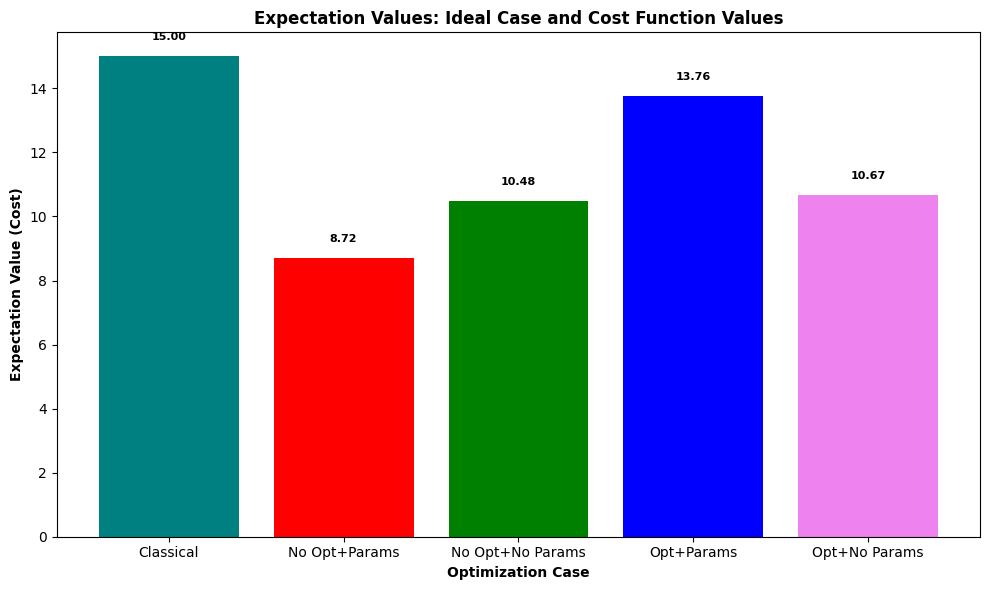

In [63]:
# Prepare bar plot labels and values
#labels = ["Classical Solution", "Without Optimizer and with parameters", "With Optimizer and with parameters", "without optimizer and with parameter", "with optimizer and without parameter"]# + [f"Layer {m+1}" for m in range(p)]
values = [sol, expectation_full_without_optimizer, expectation_full_without_optimizer_without_parameter_transfer, expectation_full_with_optimizer, expectation_full_with_optimizer_without_parameter_transfer]# + cost_function_values
labels = ["Classical", "No Opt+Params", "No Opt+No Params", "Opt+Params", "Opt+No Params"]
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='teal')
plt.ylabel("Expectation Value (Cost)", fontweight='bold')
plt.xlabel("Optimization Case", fontweight='bold')
# Add values on top of each bar
colors = ['teal', 'red', 'green', 'blue', 'violet']
plt.bar(labels, values, color=colors)
for i, value in enumerate(values):
    plt.text(i, value + 0.5, f"{value:.2f}", ha='center', fontsize=8, fontweight='bold')
plt.title("Expectation Values: Ideal Case and Cost Function Values", fontweight='bold')
#plt.xticks(rotation=15, fontsize=10)
plt.tight_layout()
plt.savefig("expectation_values_comparison_10.pdf", dpi=300, bbox_inches='tight')
plt.show()

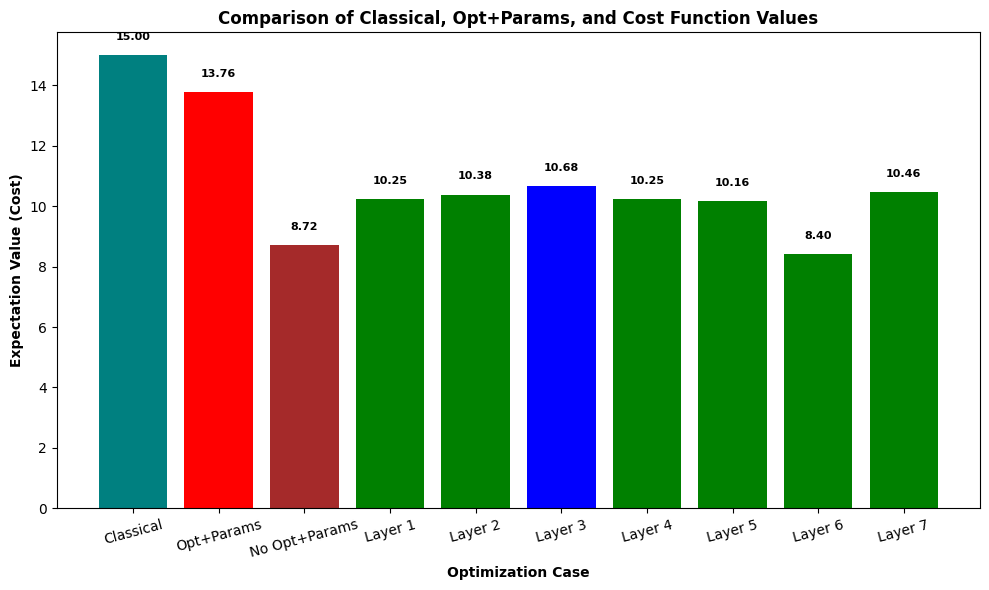

In [64]:
# Prepare bar plot labels and values
labels = ["Classical", "Opt+Params", "No Opt+Params"] + [f"Layer {m+1}" for m in range(len(cost_function_values))]
values = [sol, expectation_full_with_optimizer, expectation_full_without_optimizer] + cost_function_values

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='orange')
plt.ylabel("Expectation Value (Cost)", fontweight='bold')
for i, value in enumerate(values):
    plt.text(i, value + 0.5, f"{value:.2f}", ha='center', fontsize=8, fontweight='bold')
plt.xlabel("Optimization Case", fontweight='bold')
colors = ['teal', 'red', 'brown', 'green', 'green', 'blue', 'green', 'green', 'green', 'green']
plt.bar(labels, values, color=colors)
plt.title("Comparison of Classical, Opt+Params, and Cost Function Values", fontweight='bold')
plt.xticks(rotation=15, fontsize=10)
plt.tight_layout()
plt.savefig("Layer_selective comparision_2.pdf", dpi=300, bbox_inches='tight')
plt.show()